In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [2]:
bolTrainagain = False # will try to load data if false 

In [3]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=0
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 3 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  4961.598765432074
Friday area:  4076.986111111094
Weekend area:  862.1666666666708
Weekday maximum:  217.03703703703704
Friday maximum:  187.5
Weekend maximum:  36.92857142857143


## MATHEMATICAL MODEL - CDF Subtraction

In [4]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_areanormalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_areanormalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_areanormalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})
if not(bolTrainagain):
    try:
        with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
            [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                 errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
            f.close()
    except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
        print('no saved data: recalcualting')
        bolTrainagain = True

if bolTrainagain:

    errors_wd = np.ones(np.shape(training_weekdays_norm))
    optimal_params_weekdaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_weekdays_norm, errors_wd),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 10000})


In [5]:
var_weekdaytn = np.mean(errors_wd)
stdv_weekdaytn=math.sqrt(var_weekdaytn)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors_wd,0))
#print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.00172



In [6]:
def plot_model_tn(loc_ar=.3, scale_ar=.05, loc_de=.8, scale_de=.1):
    fsize=9
    # arrivals
    a_ar = -loc_ar/scale_ar
    b_ar = (1-loc_ar)/scale_ar

    # departures
    a_de = -loc_de/scale_de
    b_de = (1-loc_de)/scale_de

    pdf_ar = truncnorm.pdf(time_tn, a_ar, b_ar, loc=loc_ar, scale=scale_ar)
    pdf_de = truncnorm.pdf(time_tn, a_de, b_de, loc=loc_de, scale=scale_de)
    cdf_ar = truncnorm.cdf(time_tn, a_ar, b_ar, loc=loc_ar, scale=scale_ar)
    cdf_de = truncnorm.cdf(time_tn, a_de, b_de, loc=loc_de, scale=scale_de)

    #fig, ax = plt.subplots(2,figsize=(18,10))
    fig, ax = plt.subplots(2,figsize=(7,4))
    ax[0].plot(time, pdf_ar/sum(pdf_ar) , '-b',label='PDF arrivals')
    ax[0].plot(time, pdf_de/sum(pdf_de), '-r',label='PDF departures')
    ax[0].set_title('PDFs', fontsize=fsize)
    ax[0].legend(fontsize=fsize, loc="upper right");
    ax[0].set_ylabel('probability', fontsize = fsize)
    ax[0].grid(which='major',linestyle='dotted')
    ax[0].set_xlim([0,23.5])
    ax[0].tick_params(axis='both', which='major', labelsize=fsize)
    
    #ax[1].plot(time, cdf_ar , '--b',label='CDF arrivals')
    h2,=ax[1].plot(time, cdf_de, '--r',label='CDF departures')
    h3,=ax[1].plot(time, cdf_ar-cdf_de, 'r',linewidth=3,label='TN model')
    h1,=ax[1].plot(time, cdf_ar , '--b',label='CDF arrivals')
    ax[1].set_title('CDFs', fontsize=fsize)
    #ax[1].legend(fontsize=fsize, loc="best")
    ax[1].legend(handles=[h1, h2 , h3],fontsize=fsize, loc="upper left")
    ax[1].grid(which='major',linestyle='dotted')
    ax[1].set_xlim([0,23.5])
    ax[1].set_xlabel('hour', fontsize = fsize)
    ax[1].set_ylabel('occupancy', fontsize = fsize)
    ax[1].tick_params(axis='both', which='major', labelsize=fsize)
    return fig
   

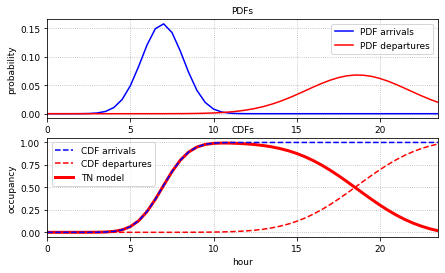

In [7]:
fid=plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],
                  optimal_params_weekdaytn.x[3])
fid.savefig('Model_'+current_parking+'.pdf',bbox_inches='tight');